# Homography

Simulate a face printed on a sheet of paper for anti-spoofing. Simulate rotations and perspective skew by warping the Datagen scene onto an arbitraty bounded plane.

### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import datagen

from skimage.transform import warp
from skimage import data

Load a datapoint

In [2]:
dataset = datagen.load('../resources/faces_1')
dp = dataset[0]
im_src = dp.visible_spectrum

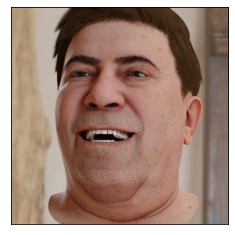

In [3]:
plt.imshow(im_src);
plt.xticks([])
plt.yticks([]);

## Rotation and Translation

Create a tranformation matrix for translation and rotation

In [4]:
theta  = -10*(np.pi/180)
xtrans = -500
ytrans = -200
scale = 0.7
paper_plane= np.array([[np.cos(theta), -np.sin(theta), xtrans], [np.sin(theta), np.cos(theta), ytrans], [0, 0, scale]])

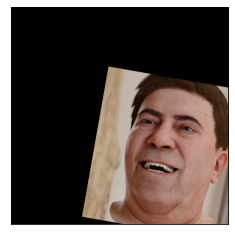

In [5]:
warped = warp(im_src, paper_plane)
plt.imshow(warped);
plt.xticks([])
plt.yticks([]);

## Perspective warp

Define a plane in 3D coordinates, warp image onto this plane

In [6]:
height, width, dim = im_src.shape
p_width = 0.2
p_height = 0.2
paperY = 0
paper_tilt = .01

dst_world_4corners= np.array([[p_width/2*-1, paperY,  p_height],
                     [(p_width/2), paperY + paper_tilt, p_height],
                     [(p_width/2) , paperY + paper_tilt, 0] ,
                     [(p_width/2)*-1,paperY, 0]])

Transform the 4 corner points into image coordiates

In [7]:
kpts_3d_homogeneous = np.hstack([dst_world_4corners, np.ones((4, 1))])
kpts_3d_cam = (dp.camera_metadata.extrinsic_matrix @ kpts_3d_homogeneous.T).T
kpts_2d_img_homogenous = (dp.camera_metadata.intrinsic_matrix @ kpts_3d_cam.T).T
kpts_2d_img = kpts_2d_img_homogenous[:, :2] / kpts_2d_img_homogenous[:, 2][:, np.newaxis]

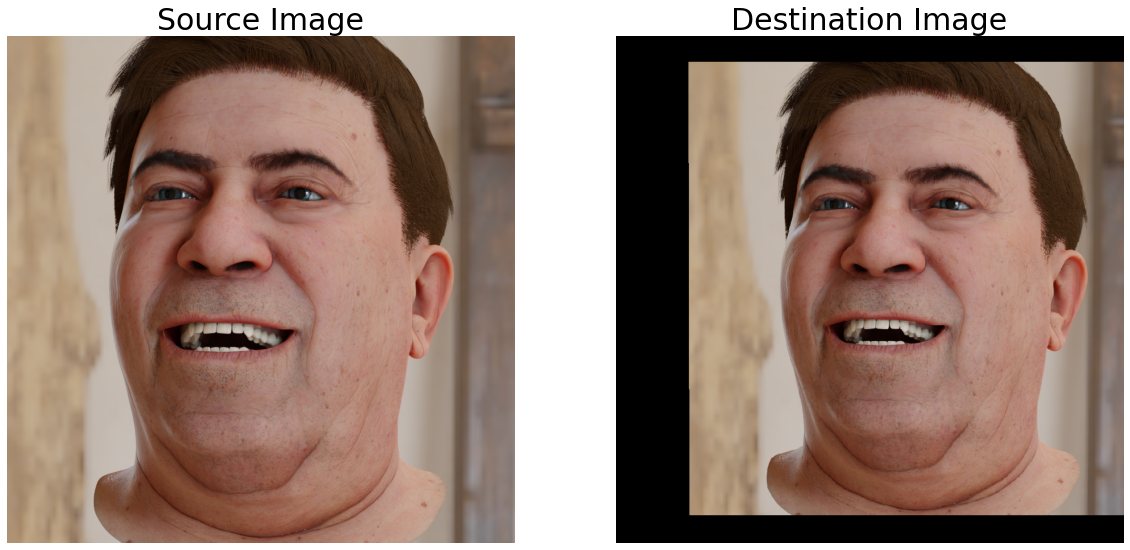

In [8]:
im_dst = im_src.copy()
im_dst[np.all(im_dst, axis=-1)] = (0,0,0)

#init ProjectiveTransform object
pt = transform.ProjectiveTransform()
src = np.array([[ 0., 0.],
       [height-1, 0.],
       [height-1, width-1],
       [ 0., width-1]])

dst = np.round(kpts_2d_img,0).astype(int)

#estimate the transformation
pt.estimate(src, dst)

x, y = np.mgrid[:im_dst.shape[0], :im_dst.shape[1]]
dst_indxs=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))

#apply transform
src_indxs = np.round(pt.inverse(dst_indxs), 0).astype(int)

#clip image to fit the dest
valid_idx = np.where((src_indxs[:,0] < height) & (src_indxs[:,1] < width) & (src_indxs[:,0] >= 0) & (src_indxs[:,1] >= 0))

valid_dst_indxs = dst_indxs[valid_idx]
valid_src_indxs = src_indxs[valid_idx]

im_dst[valid_dst_indxs[:,0],valid_dst_indxs[:,1]] = im_src[valid_src_indxs[:,0],valid_src_indxs[:,1]]

plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(im_src, cmap='gray'), plt.axis('off'), plt.title('Source Image', size=30)
plt.subplot(122), plt.imshow(im_dst, cmap='gray'), plt.axis('off'), plt.title('Destination Image', size=30)
#plt.subplot(122).scatter(dst[:,1],dst[:,0], s=100, c=[[0,1,0]])
plt.show()

Left: Original Image. Right: Red Dots represent the 4 corner of the destination plane. Image warped onto destination plane.